In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, random_split
from net.base_net import CuiNet, ViT_1D
from data.load_dataset import SoilSpectralDataSet
from utils.training import train
from utils.testing import test


In [2]:

################################### SEEDING ###################################
# Set seed for reproducibility (for dataset splitting)
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
###############################################################################
    
################################# SET DEVICE ##################################
device = torch.device("cuda:0" )
###############################################################################
    
############################# DEFINE TRAINING PARAMS ##########################
num_epochs = 1000
BATCH = 1_000
LR = 0.001
save_interval = 50  # Save model every 10 epochs
user= os.environ.get('USERNAME')
y_labels = ["oc_usda.c729_w.pct"]

# Load dataset and create DataLoader with seed
spectral_data = SoilSpectralDataSet(data_path=None, dataset_type="mir", y_labels=y_labels)
spec_dims=spectral_data.spec_dims


In [3]:
train_size = int(0.9 * len(spectral_data))
val_size = len(spectral_data) - train_size
train_dataset, val_dataset = random_split(spectral_data, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

###############################################################################
#####################    Standardize the data  ################################

mean = np.zeros(spec_dims) 
std = np.zeros(spec_dims)

for inputs, targets in train_loader:
    mean += np.sum(np.array(inputs),axis = 0)                          
mean /= len(train_loader.dataset)

for inputs, targets in train_loader:
    std += np.sum((np.array(inputs)-mean)**2,axis = 0)        
std /= len(train_loader.dataset)



In [3]:

###############################################################################
model_name = "CuiNet_OSSL"
data_path = os.getcwd() + "/data/dataset/oss/"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = CuiNet(spec_dims, mean = mean,std = std, out_dims=len(y_labels)) 
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss(reduction='none')
criterion_test = nn.MSELoss(reduction='none')
print(model)


train_losses, val_losses,val_r2_scores,final_path =train(model, optimizer, criterion, train_loader, val_loader, num_epochs, save_path=save_path, save_interval=save_interval, classification = False)

CuiNet(
  (conv1d): Conv1d(1, 1, kernel_size=(5,), stride=(1,))
  (fc1): Linear(in_features=1697, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=18, bias=True)
  (fc3): Linear(in_features=18, out_features=12, bias=True)
  (out): Linear(in_features=12, out_features=2, bias=True)
)
Epoch 1/1000 | Train Losses: y 0: 361.4845, y 1: 395.0197 | Validation Losses: y 0: 47.2817, y 1: 35.0083 | R2 Scores: y 0: -0.0941, y 1: -0.0071
Epoch 2/1000 | Train Losses: y 0: 42.7644, y 1: 45.7398 | Validation Losses: y 0: 16.4648, y 1: 17.6324 | R2 Scores: y 0: -0.0973, y 1: 0.0032
Epoch 3/1000 | Train Losses: y 0: 21.7094, y 1: 22.8314 | Validation Losses: y 0: 9.6660, y 1: 10.6699 | R2 Scores: y 0: -0.1079, y 1: -0.0080
Epoch 4/1000 | Train Losses: y 0: 14.9061, y 1: 13.8949 | Validation Losses: y 0: 6.8456, y 1: 6.7384 | R2 Scores: y 0: -0.1258, y 1: -0.0026
Epoch 5/1000 | Train Losses: y 0: 11.5281, y 1: 9.5162 | Validation Losses: y 0: 4.9869, y 1: 4.5135 | R2 Scores: y 0: 

KeyboardInterrupt: 

CCC: 0.9194553777400745, R2: 0.816242753973621, RMSEP: 0.3398079097635509


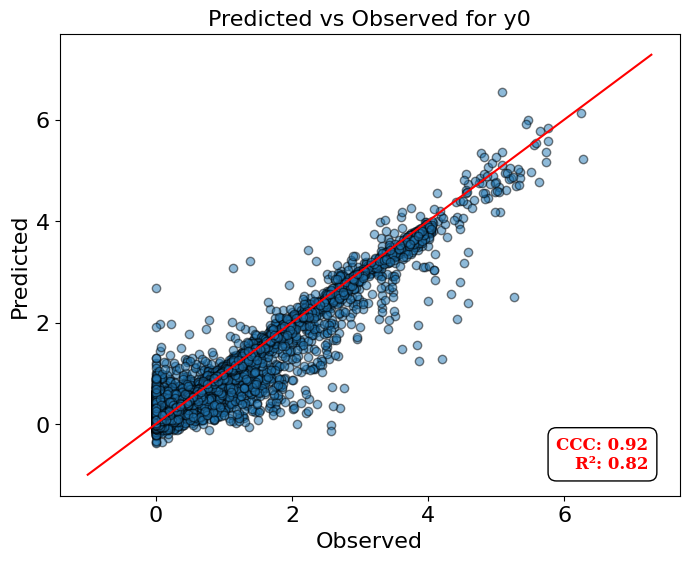

CCC: 0.9896482473976969, R2: 0.9783679073759092, RMSEP: 0.1275197763837328


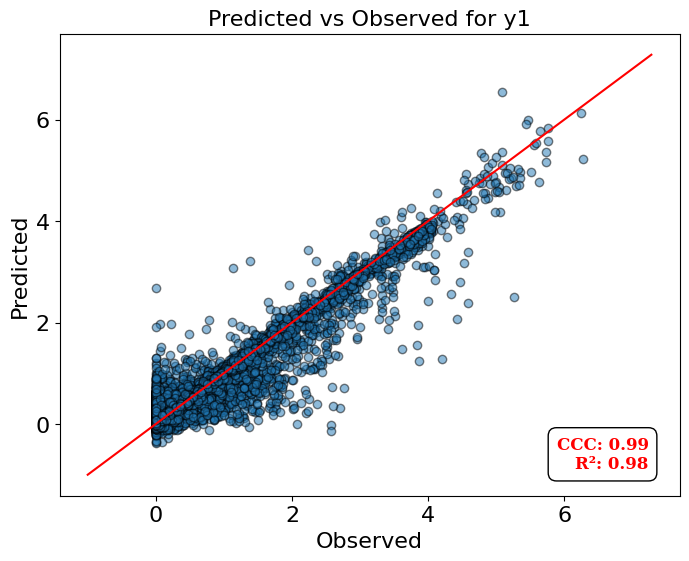

In [21]:
test(model,final_path,val_loader)

In [4]:
############################# DEFINE TRAINING PARAMS ##########################
num_epochs = 1000
LR = 0.01
save_interval = 50  # Save model every 10 epochs

model_name ="_ViT_1D_OSSL_"  

data_path = os.getcwd() + "/data/dataset/oss/"
save_path = os.path.dirname(data_path) + f'/models/{model_name}/' + model_name

model = ViT_1D(mean = mean,std = std, seq_len = spec_dims, patch_size = 50, dim_embed = 128, trans_layers = 20, heads = 8, mlp_dim = 512, out_dims =1, dropout=0.1) 

optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=0.003/2)
criterion = nn.MSELoss()

train_losses, val_losses,val_r2_scores,final_path =train(model, optimizer, criterion, train_loader, val_loader, num_epochs, save_path=save_path,save_interval=save_interval, classification = False)


Epoch 1/1000 | Train Losses: y 0: 1.8406 | Validation Losses: y 0: 1.1689 | R2 Scores: y 0: -109.6045
Epoch 2/1000 | Train Losses: y 0: 0.3807 | Validation Losses: y 0: 0.1161 | R2 Scores: y 0: 0.9046
Epoch 3/1000 | Train Losses: y 0: 0.2520 | Validation Losses: y 0: 0.1080 | R2 Scores: y 0: 0.9058
Epoch 4/1000 | Train Losses: y 0: 0.1199 | Validation Losses: y 0: 0.1030 | R2 Scores: y 0: 0.9117
Epoch 5/1000 | Train Losses: y 0: 0.2188 | Validation Losses: y 0: 0.0898 | R2 Scores: y 0: 0.9269
Epoch 6/1000 | Train Losses: y 0: 0.0897 | Validation Losses: y 0: 0.0714 | R2 Scores: y 0: 0.9377
Epoch 7/1000 | Train Losses: y 0: 0.0780 | Validation Losses: y 0: 0.0757 | R2 Scores: y 0: 0.9406
Epoch 8/1000 | Train Losses: y 0: 0.0714 | Validation Losses: y 0: 0.0923 | R2 Scores: y 0: 0.9220
Epoch 9/1000 | Train Losses: y 0: 0.0708 | Validation Losses: y 0: 0.0668 | R2 Scores: y 0: 0.9517
Epoch 10/1000 | Train Losses: y 0: 0.0747 | Validation Losses: y 0: 0.0634 | R2 Scores: y 0: 0.9465
Epoch 

KeyboardInterrupt: 

CCC: 0.9824631183910775, R2: 0.9646937890256678, RMSEP: 0.21197264792864118


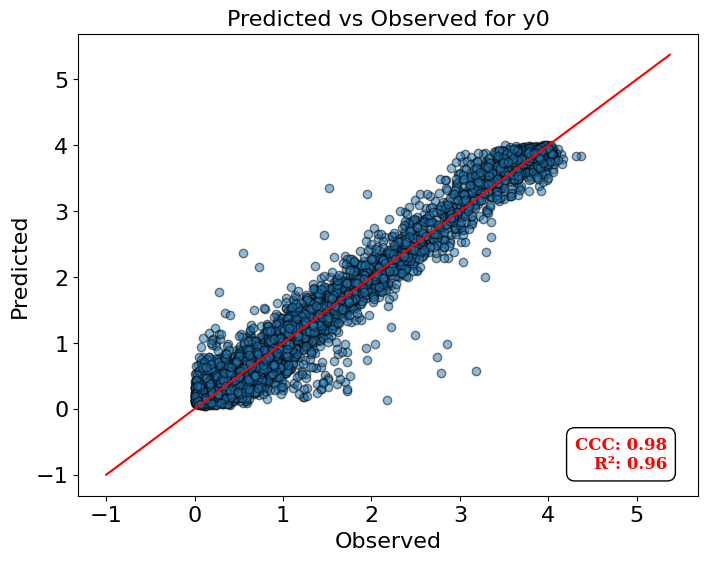

In [5]:

test(model, "/home/metz/deepchemometrics/Aioly/data/dataset/oss/models/_ViT_1D_OSSL_/_ViT_1D_OSSL__final.pth", val_loader)